In [1]:
from nltk.tokenize import sent_tokenize
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import glob
import os
from os import path
import string
import numpy
import re
from __future__ import absolute_import, division, print_function
import pandas as pd
import multiprocessing
import gensim
import random
from tqdm import tqdm
import pandas as pd
from gensim.models import KeyedVectors
from numpy import array
import matplotlib.pyplot as plt
import numpy as np

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
def measure_semantic_shift_by_neighborhood(model1,model2,word, neg_word,k=10,verbose=False):
	"""
	Basic implementation of William Hamilton (@williamleif) et al's measure of semantic change
	proposed in their paper "Cultural Shift or Linguistic Drift?" (https://arxiv.org/abs/1606.02821),
	which they call the "local neighborhood measure." They find this measure better suited to understand
	the semantic change of nouns owing to "cultural shift," or changes in meaning "local" to that word,
	rather than global changes in language ("linguistic drift") use that are better suited to a
	Procrustes-alignment method (also described in the same paper.)
	
	Arguments are:
	- `model1`, `model2`: Are gensim word2vec models.
	- `word` is a sting representation of a given word.
	- `k` is the size of the word's neighborhood (# of its closest words in its vector space).
	"""
	# Import function for cosine distance
	from scipy.spatial.distance import cosine
	
	# Check that this word is present in both models
	if not word in model1.vocab or not word in model2.vocab:
		print("!! Word %s not present in both models." % word)
		return None
	
	# Get the two neighborhoods
	neighborhood1 = [w for w,c in model1.most_similar(positive = [word],topn=k, negative = [neg_word])]
	neighborhood2 = [w for w,c in model2.most_similar(positive = [word],topn=k, negative = [neg_word])]
	
	# Print?
	if verbose:
		print( '>> Neighborhood of associations of the word "%s" in model1:' % word)
		print( ', '.join(neighborhood1))
		print('')
		print( '>> Neighborhood of associations of the word "%s" in model2:' % word)
		print( ', '.join(neighborhood2))
		print('')
	
	# Get the 'meta' neighborhood (both combined)
	meta_neighborhood = list(set(neighborhood1)|set(neighborhood2))
	
	# Filter the meta neighborhood so that it contains only words present in both models
	meta_neighborhood = [w for w in meta_neighborhood if w in model1.vocab and w in model2.vocab]
	
	# For both models, get a similarity vector between the focus word and all of the words in the meta neighborhood
	vector1 = [model1.similarity(word,w) for w in meta_neighborhood]
	vector2 = [model2.similarity(word,w) for w in meta_neighborhood]
	
	# Compute the cosine distance *between* those similarity vectors
	dist=cosine(vector1,vector2)
	
	# Return this cosine distance -- a measure of the relative semantic shift for this word between these two models
	return dist

In [4]:
dr = "D://Scriptie//Data//models//5yp_s175" 
os.chdir(dr)
list_mod = sorted(glob.glob('*.bin'))
list_mod

['1830_s175_5yp_model.bin',
 '1835_s175_5yp_model.bin',
 '1840_s175_5yp_model.bin',
 '1845_s175_5yp_model.bin',
 '1850_s175_5yp_model.bin',
 '1855_s175_5yp_model.bin',
 '1860_s175_5yp_model.bin',
 '1865_s175_5yp_model.bin',
 '1870_s175_5yp_model.bin',
 '1875_s175_5yp_model.bin',
 '1880_s175_5yp_model.bin',
 '1885_s175_5yp_model.bin',
 '1890_s175_5yp_model.bin',
 '1895_s175_5yp_model.bin',
 '1900_s175_5yp_model.bin',
 '1905_s175_5yp_model.bin',
 '1910_s175_5yp_model.bin']

In [6]:
ry = list(range(1830,1911,5))

sems_list = list()
for c in list(range(0,16,2)):
    
    fn1 = list_mod[c-1]
    fn2 = list_mod[c]
    
    m1 = KeyedVectors.load_word2vec_format(fn1, binary = True)
    m2 = KeyedVectors.load_word2vec_format(fn2, binary = True)
    
    print(ry[c])
    sems = measure_semantic_shift_by_neighborhood(m1,m2, 'binnenland', '', k = 10, verbose = True)
    sems_list.append(sems)

1830


C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


>> Neighborhood of associations of the word "binnenland" in model1:
binnenlandsche, buitenland, buitenlandsche, binneni, aprü, officieele, noodlijdende, corr, voornaamste, nederland

>> Neighborhood of associations of the word "binnenland" in model2:
buitenland, voorsteden, westelijke, magazijnen, oostelijke, indische, dalende, toevoeren, binnenlandsche, aangekomene

1840
>> Neighborhood of associations of the word "binnenland" in model1:
handelsberigten, binnenlandsche, buitenland, beursberigt, dalende, willige, aangekomene, 305, 244, beschadigde

>> Neighborhood of associations of the word "binnenland" in model2:
binnenlandsche, handelsberigten, buitenlandsche, buitenland, prijshoudende, 1001, 5s, beursberigt, 864, fluctuatien

1850
>> Neighborhood of associations of the word "binnenland" in model1:
binnenlandsche, buitenlandsche, buitenland, binn, 23j, 854, 22f, 21j, achteruitgegaan, harpen

>> Neighborhood of associations of the word "binnenland" in model2:
binnenlandsche, binneni,

In [7]:
dfr = pd.DataFrame([sems_list, list(range(3,16,2))]).T
dfr.columns = ['ss', 'y']

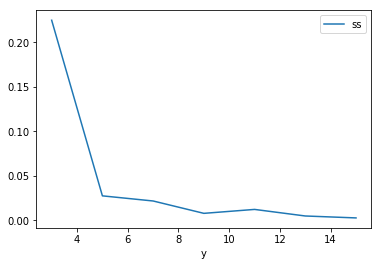

In [8]:
dfr.plot(x="y", y=["ss"], kind="line")

In [76]:
m1 = KeyedVectors.load_word2vec_format(list_mod[1], binary = True)
m2 = KeyedVectors.load_word2vec_format(list_mod[5], binary = True)
measure_semantic_shift_by_neighborhood(m1,m2, 'buitenland','', k = 30, verbose = True)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


>> Neighborhood of associations of the word "buitenland" in model1:
binnenland, handelsberigten, —», buitenlandsche, zeit, nieuwstijdingen, particuliere, correspondentien, vasteland, duitsche, augsb, grootbrittannie, duitschland, turkye, klimmende, drukke, italie, oosten, allgemeine, binnenlandsche, bankact, 12j, allg, ongewone, 2504, oostersche, metalliek, 17j, 10j, bankaktien
>> Neighborhood of associations of the word "buitenland" in model2:
buitenlandsche, binnenland, binnenlandsche, binneni, voornaamste, bedroegen, binn, europeesche, buitenlands, levendiger, gezegende, beliepen, flaauwe, builenl, vooruitgegaan, toegenomen, grootbrittanje, duitsche, vasteland, bestuurt, totale, bekrompen, ongunstiger, gunstiger, vreemde, ongehoorde, hoogere, duitschland, ongunstige, europa


0.1286379098892212

In [23]:
for i in range(1,16):
    m1 = KeyedVectors.load_word2vec_format(list_mod[i-1], binary = True)
    m2 = KeyedVectors.load_word2vec_format(list_mod[i], binary = True)
    
    print(measure_semantic_shift_by_neighborhood(m1,m2, 'binnenland', '', k = 25, verbose = False))

C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.18554800748825073
0.0537257194519043
0.03991955518722534
0.04524731636047363
0.018369019031524658
0.013893842697143555
0.006007194519042969
0.0147627592086792
0.010668277740478516
0.009184062480926514
0.01146697998046875
0.009994745254516602
0.007105648517608643
0.005584716796875
0.01022195816040039


In [26]:
m1 = KeyedVectors.load_word2vec_format(list_mod[0], binary = True)
m2 = KeyedVectors.load_word2vec_format(list_mod[16], binary = True)
measure_semantic_shift_by_neighborhood(m1,m2, 'binnenland', '', k = 25, verbose = True)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


>> Neighborhood of associations of the word "binnenland" in model1:
buitenland, voorsteden, westelijke, magazijnen, oostelijke, indische, dalende, toevoeren, binnenlandsche, aangekomene, afgelegene, binnenste, bloeijende, landsche, klimaat, rijzende, china, omliggende, pera, geanimeerd, stremming, vertier, willige, koren, moederland

>> Neighborhood of associations of the word "binnenland" in model2:
binnenlandsche, buitenland, buitenlandsche, binneni, aprü, officieele, noodlijdende, corr, voornaamste, nederland, vermogt, financieele, geëindigde, binn, msterdam, stadsnieuws, onze, omliggende, 21j, beursoverzicht, binnenlandsch, rooskleurig, scheepstijdingen, achteruitgegaan, noordelijke



0.34513193368911743

In [19]:
list_mod

['1830_s175_5yp_model.bin',
 '1835_s175_5yp_model.bin',
 '1840_s175_5yp_model.bin',
 '1845_s175_5yp_model.bin',
 '1850_s175_5yp_model.bin',
 '1855_s175_5yp_model.bin',
 '1860_s175_5yp_model.bin',
 '1865_s175_5yp_model.bin',
 '1870_s175_5yp_model.bin',
 '1875_s175_5yp_model.bin',
 '1880_s175_5yp_model.bin',
 '1885_s175_5yp_model.bin',
 '1890_s175_5yp_model.bin',
 '1895_s175_5yp_model.bin',
 '1900_s175_5yp_model.bin',
 '1905_s175_5yp_model.bin',
 '1910_s175_5yp_model.bin']